In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../analysis/

/Users/dorislee/Desktop/Research/seg/final_segmentation/analysis


In [3]:
%load_ext autoreload
%autoreload 2
from PixelEM import *

/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
ls pixel_em/5workers_rand0/obj1/clust0/

EM_mask_thresh0.png                      EM_prj_iter1_thresh3.14460768132.json    EM_prj_iter4_thresh0.json                Qj_4_thresh3.14460768132.pkl             p_in_mask_4_thresh3.14460768132.pkl
EM_mask_thresh3.14460768132.png          EM_prj_iter2_thresh0.json                EM_prj_iter4_thresh3.14460768132.json    gt_est_mask_4_thresh0.pkl                p_not_in_mask_4_thresh0.pkl
EM_prj_iter0_thresh0.json                EM_prj_iter2_thresh3.14460768132.json    MV_mask.pkl                              gt_est_mask_4_thresh3.14460768132.pkl    p_not_in_mask_4_thresh3.14460768132.pkl
EM_prj_iter0_thresh3.26339400141.json    EM_prj_iter3_thresh0.json                MV_prj.json                              mega_mask.pkl                            voted_workers_mask.pkl
EM_prj_iter1_thresh0.json                EM_prj_iter3_thresh3.14460768132.json    Qj_4_thresh0.pkl                         p_in_mask_4_thresh0.pkl                  worker_ids.json


In [4]:
sample = "5workers_rand0"
objid =1 
cluster_id=0
p,r,j = compute_PRJ_MV(sample, objid,cluster_id)

In [8]:
print p,r,j

0.976204956667 0.980827986557 0.95792614696


In [6]:
do_EM_for(sample, objid,cluster_id)

Doing EM


In [9]:
import glob
for f in glob.glob("pixel_em/5workers_rand0/obj1/clust0/EM_prj_iter*_thresh0.json"):
    print open(f).read()

[0.9762049566671734, 0.9808279865566758, 0.9579261469600895]
[0.9762049566671734, 0.9808279865566758, 0.9579261469600895]
[0.9762049566671734, 0.9808279865566758, 0.9579261469600895]
[0.9762049566671734, 0.9808279865566758, 0.9579261469600895]
[0.9762049566671734, 0.9808279865566758, 0.9579261469600895]


In [11]:
exclude_isovote=False

In [13]:
import pickle as pkl

In [15]:
outdir

'/Users/dorislee/Desktop/Research/seg/final_segmentation/analysis/pixel_em/5workers_rand0/obj1/clust0/'

In [30]:
log_probability_in_mask=pkl.load(open("pixel_em/5workers_rand0/obj1/clust0/p_in_mask_4_thresh0.pkl"))
log_probability_not_in_mask =pkl.load(open('pixel_em/5workers_rand0/obj1/clust0/p_in_mask_4_thresh0.pkl'))

def estimate_gt_compute_PRJ_against_MV(log_probability_in_mask,log_probability_not_in_mask,MV,thresh,exclude_isovote=False):
    if exclude_isovote:
        Nworkers = int(sample_name.split("workers")[0])
        mega_mask = get_mega_mask(sample_name, objid,cluster_id)
        invariant_mask = np.zeros_like(mega_mask,dtype=bool)
        invariant_mask_yes = np.ma.masked_where((mega_mask==Nworkers),invariant_mask).mask
        invariant_mask_no = np.ma.masked_where((mega_mask ==0),invariant_mask).mask
    gt_est_mask = estimate_gt_from(log_probability_in_mask, log_probability_not_in_mask,thresh=thresh)
    if exclude_isovote:
        gt_est_mask = gt_est_mask+invariant_mask_yes-invariant_mask_no
        gt_est_mask[gt_est_mask<0]=False
        gt_est_mask[gt_est_mask>1]=True
        #gt_est_mask = gt_est_mask+invariant_mask_yes
    [p, r, j] = faster_compute_prj(gt_est_mask, MV)
    return [p,r,j],gt_est_mask

In [34]:
def binarySearchDeriveBestThresh(log_probability_in_mask,log_probability_not_in_mask,MV,exclude_isovote=False,rerun_existing=False):
    thresh_min = -200
    thresh_max = 200
    delta = np.abs(thresh_max -thresh_min)
    thresh = (thresh_min+thresh_max)/2.
    p,r=0,0
    while (p==-1 or delta>1):
        [p,r,j],gt_est_mask = estimate_gt_compute_PRJ_against_MV(log_probability_in_mask,log_probability_not_in_mask,MV,thresh,exclude_isovote=False)
        delta = np.abs(thresh_max -thresh_min)
        if p>r:
            right = thresh_min + 0.75*delta  
            thresh_max = right
        else: 
            left = thresh_min + 0.25*delta  
            thresh_min = left
        if p==-1:
            #if p =-1 then it is because the result area is zero, which means nothing was selected for gt
            # this meant that the threshold has overshot
            thresh_max = thresh_min+0.2*delta
        thresh = (thresh_min+thresh_max)/2.
    return p,r,j,thresh,gt_est_mask

In [35]:
def do_EM_for(sample_name, objid, cluster_id="", num_iterations=5,load_p_in_mask=False,thresh=0,rerun_existing=False,exclude_isovote=False,compute_PR_every_iter=True):
    if exclude_isovote:
        mode ='iso'
    else:
        mode =''
    if cluster_id!="":
        outdir = '{}{}/obj{}/clust{}/'.format(PIXEL_EM_DIR, sample_name, objid,cluster_id)
    else:
        outdir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, sample_name, objid)
    if not rerun_existing:
        if os.path.isfile('{}{}EM_prj_iter{}_thresh{}.json'.format(outdir,mode,num_iterations-1,thresh)) :
            print "Already ran EM, Skipped"
            return
    print "Doing EM"
    if rerun_existing:
        if os.path.isfile('{}EM_prj_thresh{}.json'.format(outdir,thresh)):
            print "Already ran, Skipped"
            return
    # initialize MV mask
    MV = get_MV_mask(sample_name, objid,cluster_id)
    gt_est_mask = MV 
    worker_masks = get_all_worker_mega_masks_for_sample(sample_name, objid,cluster_id=cluster_id)
    Nworkers= len(worker_masks)
    mega_mask = get_mega_mask(sample_name, objid,cluster_id)
    for it in range(num_iterations):
        worker_qualities = dict()
        for wid in worker_masks.keys():
            worker_qualities[wid] = worker_prob_correct(mega_mask,worker_masks[wid], gt_est_mask,Nworkers,exclude_isovote=exclude_isovote)
        if load_p_in_mask:
            #print "loaded pInT" 
            log_probability_in_mask=pkl.load(open('{}{}p_in_mask_{}.pkl'.format(outdir,mode, it)))
            log_probability_not_in_mask =pkl.load(open('{}{}p_not_in_mask_{}.pkl'.format(outdir,mode, it)))	
        else: 
            #Compute pInMask and pNotInMask 
            log_probability_in_mask, log_probability_not_in_mask = mask_log_probabilities(worker_masks, worker_qualities)
            p,r,j,thresh,gt_est_mask = binarySearchDeriveBestThresh(log_probability_in_mask,log_probability_not_in_mask, MV,exclude_isovote=False,rerun_existing=False)
            #gt_est_mask = estimate_gt_from(log_probability_in_mask, log_probability_not_in_mask,thresh=thresh)

        # Compute PR mask based on the EM estimate mask from the last iteration
        if compute_PR_every_iter:
            #[p, r, j] = faster_compute_prj(gt_est_mask, get_gt_mask(objid))
            with open('{}{}EM_prj_iter{}_thresh{}.json'.format(outdir,mode,it,thresh), 'w') as fp:
                fp.write(json.dumps([p, r, j]))
    #Only writing output at the end of all iterations: 
    pickle.dump(log_probability_in_mask,open('{}{}p_in_mask_{}_thresh{}.pkl'.format(outdir,mode, it,thresh),'w'))
    pickle.dump(log_probability_not_in_mask,open('{}{}p_not_in_mask_{}_thresh{}.pkl'.format(outdir,mode, it,thresh),'w'))
    pickle.dump(gt_est_mask,open('{}{}gt_est_mask_{}_thresh{}.pkl'.format(outdir,mode, it,thresh), 'w'))
    pickle.dump(worker_qualities,open('{}{}Qj_{}_thresh{}.pkl'.format(outdir, mode,it,thresh), 'w'))

    plt.figure()
    plt.imshow(gt_est_mask, interpolation="none")  # ,cmap="rainbow")
    plt.colorbar()
    plt.savefig('{}{}EM_mask_thresh{}.png'.format(outdir,mode,thresh))
    if not compute_PR_every_iter:
        # Compute PR mask based on the EM estimate mask from the last iteration
        [p, r, j] = faster_compute_prj(gt_est_mask, get_gt_mask(objid))
        with open('{}{}EM_prj_thresh{}.json'.format(outdir,mode,thresh), 'w') as fp:
            fp.write(json.dumps([p, r, j]))

In [6]:
do_EM_for(sample, objid,cluster_id,rerun_existing=True,num_iterations=3)

Doing EM
{184: 0.997587890625, 201: 0.99123046875, 156: 0.9953645833333333, 238: 0.9973177083333333, 52: 0.99388671875}
{184: 0.9976692708333333, 201: 0.9911490885416666, 156: 0.995283203125, 238: 0.9973990885416667, 52: 0.9938053385416666}
{184: 0.9976692708333333, 201: 0.9911490885416666, 156: 0.995283203125, 238: 0.9973990885416667, 52: 0.9938053385416666}
{184: 0.9976692708333333, 201: 0.9911490885416666, 156: 0.995283203125, 238: 0.9973990885416667, 52: 0.9938053385416666}


Doing EM
{146: 0.9997623697916667, 234: 0.9982845052083333}
{146: 0.9997623697916667, 234: 0.9982845052083333}
{146: 0.9997623697916667, 234: 0.9982845052083333}
{146: 0.9997623697916667, 234: 0.9982845052083333}
{146: 0.9997623697916667, 234: 0.9982845052083333}


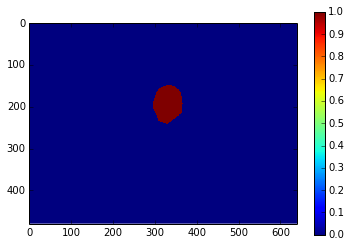

In [7]:
do_EM_for(sample, objid,1,rerun_existing=True,PLOT=True)

In [ ]:
p,r,j = compute_PRJ_MV(sample, 2,"")

In [10]:
do_EM_for(sample, 2,"",rerun_existing=True)

Doing EM
{146: 0.9991373697916667, 199: 0.99888671875, 181: 0.999296875, 118: 0.9966276041666666, 247: 0.9991145833333334}
-->[1.0, 1.0, 1.0]
{146: 0.9991373697916667, 199: 0.99888671875, 181: 0.999296875, 118: 0.9966276041666666, 247: 0.9991145833333334}
-->[1.0, 1.0, 1.0]
{146: 0.9991373697916667, 199: 0.99888671875, 181: 0.999296875, 118: 0.9966276041666666, 247: 0.9991145833333334}
-->[1.0, 1.0, 1.0]
{146: 0.9991373697916667, 199: 0.99888671875, 181: 0.999296875, 118: 0.9966276041666666, 247: 0.9991145833333334}
-->[1.0, 1.0, 1.0]
{146: 0.9991373697916667, 199: 0.99888671875, 181: 0.999296875, 118: 0.9966276041666666, 247: 0.9991145833333334}
-->[1.0, 1.0, 1.0]


Doing EM


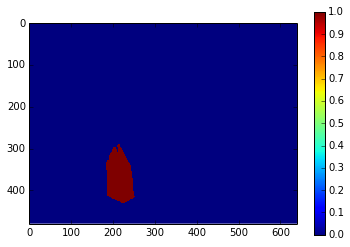

In [47]:
do_EM_for(sample, 2,"",rerun_existing=True)